# Library

In [7]:
import edward as ed
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import six 
import tensorflow as tf
from edward.models import Categorical, InverseGamma,Mixture, MultivariateNormalDiag, Normal

In [8]:
plt.style.use("ggplot")

# Data

In [12]:
def build_toy_dataset(N):
    pi = np.array([0.4, 0.6])
    mus = [[1, 1,], [-1, -1]]
    stds = [[0.1, 0.1], [0.1, 0.1]]
    x = np.zeros((N, 2), dtype=np.float32)
    for n in range(N):
        k = np.argmax(np.random.multinomial(1, pi))
        x[n, :] = np.random.multivariate_normal(mus[k], np.diag(stds[k]))
    
    return x

In [13]:
N = 500
K = 2
D = 2
ed.set_seed(42)

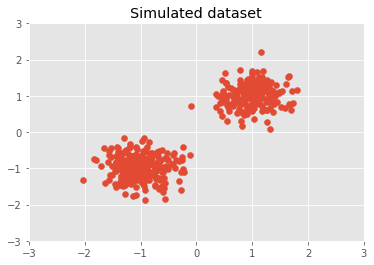

In [14]:
x_train = build_toy_dataset(N)
plt.scatter(x_train[:, 0], x_train[:, 1])
plt.axis([-3, 3, -3, 3])
plt.title("Simulated dataset")
plt.show()

# Model

In [17]:
mu = Normal(mu=tf.zeros([K, D]), sigma=tf.ones([K, D]))
sigma = InverseGamma(alpha=tf.ones([K, D]), beta=tf.ones([K, D]))
cat = Categorical(logits=tf.zeros([N, K]))

components = [
    MultivariateNormalDiag(mu=tf.ones([N, 1]) * tf.gather(mu, k),
                          diag_stdev=tf.ones([N, 1]) * tf.gather(sigma, k))
    for k in range(K)
]

x = Mixture(cat=cat, components=components)

# Inference

In [19]:
qmu = Normal(mu=tf.Variable(tf.random_normal([K, D])),
            sigma=tf.nn.softplus(tf.Variable(tf.zeros([K, D]))))
qsigma = InverseGamma(
    alpha=tf.nn.softplus(tf.Variable(tf.random_normal([K, D]))),
    beta=tf.nn.softplus(tf.Variable(tf.random_normal([K, D])))
)
inference = ed.KLqp({mu: qmu, sigma:qsigma}, data={x: x_train})
inference.initialize(n_samples=20, n_iter=4000)

In [21]:
sess = ed.get_session()
init = tf.global_variables_initializer()
init.run()

In [23]:
for _ in range(inference.n_iter):
    info_dict = inference.update()
    inference.print_progress(info_dict)
    t = info_dict["t"]
    if t % inference.n_print == 0:
        print("Inferred cluster means:")
        print(sess.run(qmu.value()))

Iteration    1 [  0%]: Loss = 4035.080
Iteration  400 [ 10%]: Loss = 1930.983
Inferred cluster means:
[[ 0.46853906 -0.44096434]
 [ 0.44212031 -0.17498754]]
Iteration  800 [ 20%]: Loss = 1240.042
Inferred cluster means:
[[-1.04005373 -0.64162743]
 [ 0.17904404  0.59977615]]
Iteration 1200 [ 30%]: Loss = 951.057
Inferred cluster means:
[[-0.78359747 -0.96310759]
 [ 0.76356339  0.98571116]]
Iteration 1600 [ 40%]: Loss = 1035.207
Inferred cluster means:
[[-1.26877379 -1.1552794 ]
 [ 1.31790948  0.96185952]]
Iteration 2000 [ 50%]: Loss = 970.676
Inferred cluster means:
[[-0.83575034 -0.81228036]
 [ 0.81297839  0.8316229 ]]
Iteration 2400 [ 60%]: Loss = 892.210
Inferred cluster means:
[[-1.1592958  -0.89578563]
 [ 0.79022789  1.03443909]]
Iteration 2800 [ 70%]: Loss = 901.602
Inferred cluster means:
[[-1.10362434 -1.17149103]
 [ 0.8637886   1.12806857]]
Iteration 3200 [ 80%]: Loss = 855.882
Inferred cluster means:
[[-1.01542878 -0.98210287]
 [ 0.8931005   1.18952906]]
Iteration 3600 [ 90%]:

# Calculate likelihood for each data 

In [27]:
mu_sample = qmu.sample(100)
sigma_sample = qsigma.sample(100)
x_post = Normal(mu=tf.ones([N, 1, 1, 1]) * mu_sample,
               sigma=tf.ones([N, 1, 1, 1]) * sigma_sample)
x_broadcasted = tf.tile(tf.reshape(x_train, [N, 1, 1, D]), [1, 100, K, 1])

# Sum over latent dimension 

In [28]:
log_liks = x_post.log_prob(x_broadcasted)
log_liks = tf.reduce_sum(log_liks, 3)
log_liks = tf.reduce_mean(log_liks, 1)

# Choose the Cluster

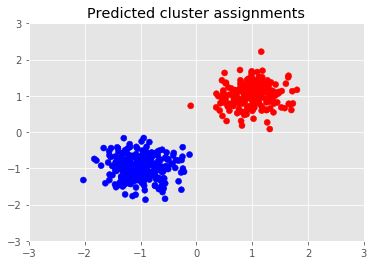

In [29]:
cluster = tf.argmax(log_liks, 1).eval()
plt.scatter(x_train[:, 0], x_train[:, 1], c=cluster, cmap=cm.bwr)
plt.axis([-3, 3, -3, 3])
plt.title("Predicted cluster assignments")
plt.show()